## Import Libraries and dataset into dataframe

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [208]:
#import the dataset from website
dfs = pd.read_html('https://github.com/Ted-Wen-311/data/blob/main/spam.csv')
df = dfs[0]
df.head()

,Unnamed: 0,v1,v2
0,NaN,ham,"Go until jurong point, crazy.. Available only ..."
1,NaN,ham,Ok lar... Joking wif u oni...
2,NaN,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,NaN,ham,U dun say so early hor... U c already then say...
4,NaN,ham,"Nah I don't think he goes to usf, he lives aro..."


In [209]:
#The unnamed column is first removed to "a", otherwise it could not be dropped

In [210]:
df.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)

In [211]:
df.drop(["a"], axis=1, inplace=True)

In [212]:
df.rename(columns={'v1': 'type', 'v2': 'text'}, inplace=True)

In [213]:
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [214]:
#check the shape of the data frame
df.shape

(5572, 2)

In [215]:
df.describe()

,type,text
count,5572,5572
unique,2,5158
top,ham,"Sorry, I'll call later"
freq,4825,30


In [216]:
df.dtypes

type    object
text    object
dtype: object

In [217]:
#Check for null values
df.isnull().sum()

type    0
text    0
dtype: int64

## Visualization

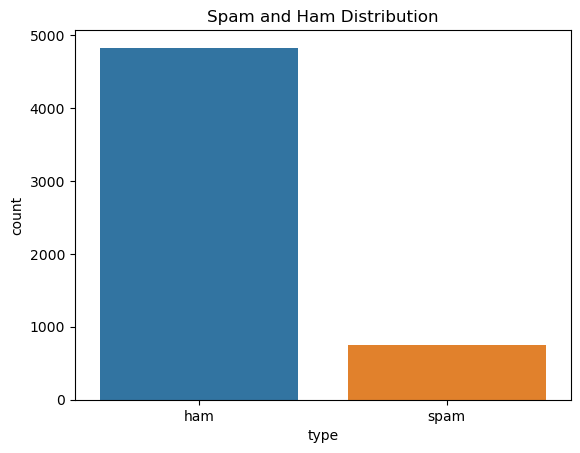

In [218]:
#Distribution of Spam and Ham texts
class_distribution = df['type'].value_counts().sort_index()
plt.figure()
ax = sns.countplot(x='type', data=df, order = class_distribution.index)
plt.title('Spam and Ham Distribution')
plt.show()

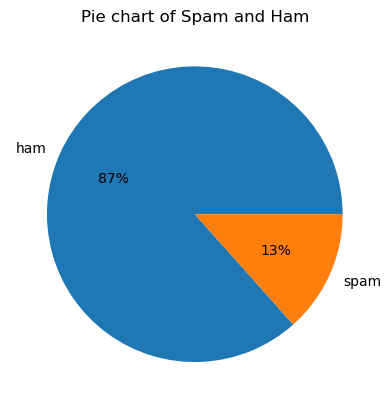

In [219]:
#pie chart shows the percentage difference better
count_Class=pd.value_counts(df["type"], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Pie chart of Spam and Ham')
plt.ylabel('')
plt.show()

<font size = "5">Week 5 feature engineering below</font>

In [220]:
#create a new column that represents ham as 0 and spam as 1
def transfer(x):
    if x == 'spam':
        return 1
    else:
        return 0
    

df['num_type'] = df['type'].apply(transfer)

In [221]:
#create a new column that counts the length of all the rows in "text" column
type = pd.get_dummies(df["type"])
df2 = pd.concat([df, type], axis=1)
df2.drop('type',axis=1,inplace=True)

df["length"] = df["text"].apply(len)

ham = df.loc[np.where(df2['ham'] == 1)].reset_index()
spam = df.loc[np.where(df2['ham'] == 0)].reset_index()

ham.drop('index',axis=1,inplace=True)
spam.drop('index',axis=1,inplace=True)

In [222]:
df.head()

,type,text,num_type,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


<AxesSubplot: xlabel='length', ylabel='Count'>

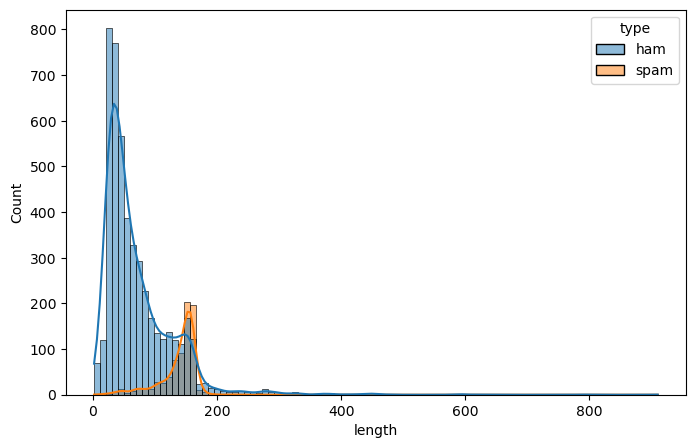

In [223]:
#lenghth distribution of spam and ham texts
plt.figure(figsize=(8,5))
sns.histplot(x='length',data=df,kde=True,hue='type')

array([<AxesSubplot: title={'center': 'ham'}>,
       <AxesSubplot: title={'center': 'spam'}>], dtype=object)

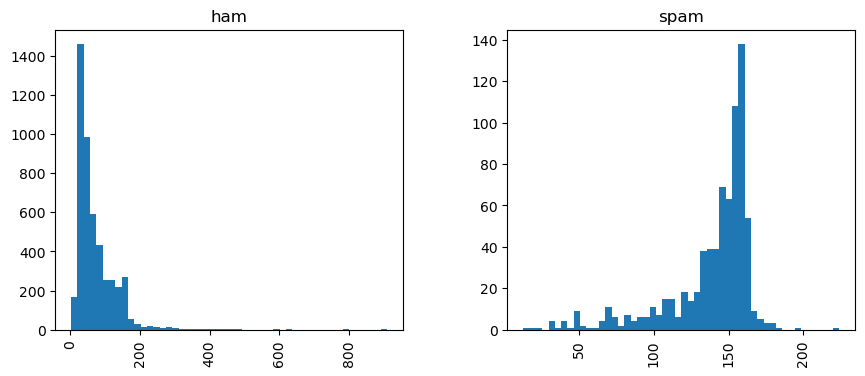

In [224]:
df.hist(column='length', by='type', bins=50,figsize=(10,4))

In [225]:
#create a new column that counts the number of long numbers in "text" column
df['long_number'] = df['text'].apply(lambda x : len(re.findall('\d{7,}',x)))

In [226]:
#create a new column that counts the number of short numbers in "text" column
df['short_number'] = df['text'].apply(lambda x : len(re.findall('\d{4,6}',x)))

In [227]:
from matplotlib import pyplot

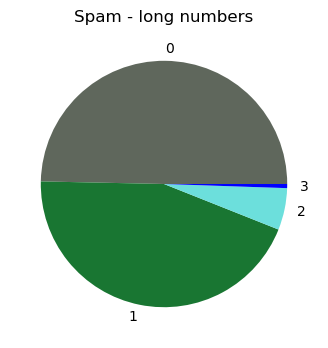

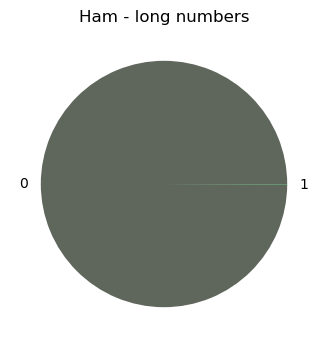

In [228]:
#plot the distribution of long numbers in spam and ham texts
pyplot.figure(figsize=(4,4))
pyplot.pie(df[df['type']=='spam']['long_number'].value_counts(),labels=['0','1','2','3'], 
           colors=['#5f675c','#197632','#6cdfdc','blue'],)
pyplot.title("Spam - long numbers")
pyplot.show()


pyplot.figure(figsize=(4,4))
pyplot.pie(df[df['type']=='ham']['long_number'].value_counts(),labels=['0','1'], 
           colors=['#5f675c','#197632'],)
pyplot.title("Ham - long numbers")
pyplot.show()

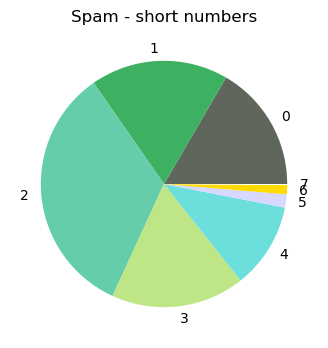

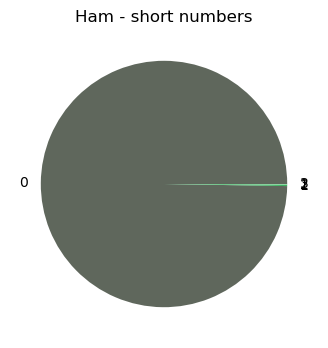

In [229]:
#plot the distribution of short numbers in spam and ham texts
green_pallete = ['#5f675c','#3db161','#66cdaa','#bee687','#6cdfdc','#d7d7ff','#ffdb00','white']

spam_x = df[df['type']=='spam']['short_number'].value_counts()
spam_x.sort_index(inplace=True)
pyplot.figure(figsize=(4,4))
pyplot.pie(spam_x,labels=spam_x.index,startangle=0,colors=green_pallete)
pyplot.title("Spam - short numbers")
pyplot.show()

ham_x = df[df['type']=='ham']['short_number'].value_counts()
ham_x.sort_index(inplace=True)
pyplot.figure(figsize=(4,4))
pyplot.pie(ham_x,labels=ham_x.index, colors=green_pallete)
pyplot.title("Ham - short numbers")
pyplot.show()

It is pretty clear that spam texts are more likely to have long numbers and short numbers than ham texts, these two features will be included in the models

## Data Preprocessing and text cleaning

In [230]:
import string
import nltk

In [231]:
stopwords= nltk.corpus.stopwords.words('english')

def clean(sentence):
    s = "".join(x for x in sentence if x not in string.punctuation)
    temp = s.lower().split(' ')
    temp2 = [x for x in temp if x not in stopwords]
    return temp2
clean(df['text'])

['go',
 'jurong',
 'point,',
 'crazy..',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet...',
 'cine',
 'got',
 'amore',
 'wat...ok',
 'lar...',
 'joking',
 'wif',
 'u',
 'oni...free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005.',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'question(std',
 'txt',
 "rate)t&c's",
 'apply',
 "08452810075over18'su",
 'dun',
 'say',
 'early',
 'hor...',
 'u',
 'c',
 'already',
 'say...nah',
 'think',
 'goes',
 'usf,',
 'lives',
 'around',
 'thoughfreemsg',
 'hey',
 'darling',
 '3',
 "week's",
 'word',
 'back!',
 "i'd",
 'like',
 'fun',
 'still?',
 'tb',
 'ok!',
 'xxx',
 'std',
 'chgs',
 'send,',
 'å£1.50',
 'rcveven',
 'brother',
 'like',
 'speak',
 'me.',
 'treat',
 'like',
 'aids',
 'patent.as',
 'per',
 'request',
 "'melle",
 'melle',
 '(oru',
 'minnaminunginte',
 'nurungu',
 "vettam)'",
 'set',
 'callertune',
 'callers.',
 'press',
 '*9',
 'copy',
 'friends',
 'caller

In [232]:
df.head()

,type,text,num_type,length,long_number,short_number
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,0,0
1,ham,Ok lar... Joking wif u oni...,0,29,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,1,4
3,ham,U dun say so early hor... U c already then say...,0,49,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,0,0


In [233]:
#WordCloud

In [234]:
#Wordcloud for ham text

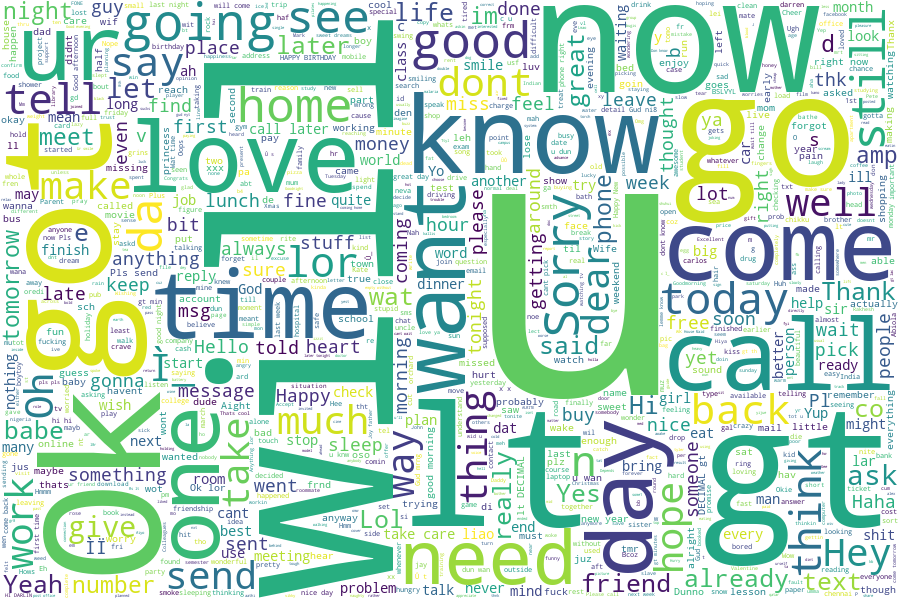

In [235]:
ham = " ".join(df[df['type'] == 'ham']['text'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 1000, background_color ='white').generate(ham)
wordcloud.generate(ham)
wordcloud.to_image()

In [236]:
#Wordcloud for spam texts

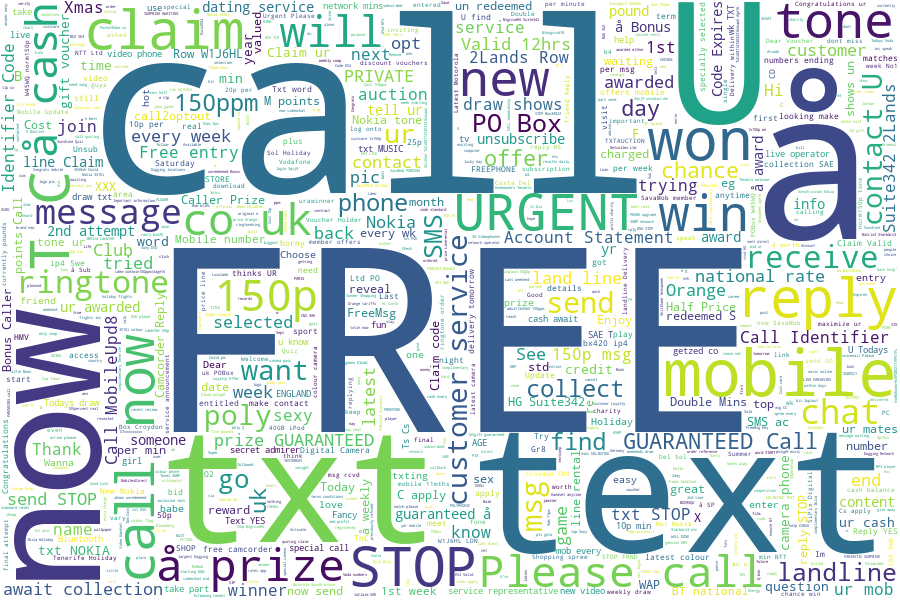

In [237]:
spam = " ".join(df[df['type'] == 'spam']['text'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 1000, background_color ='white').generate(spam)
wordcloud.generate(spam)
wordcloud.to_image()

## EDA

In [47]:
#N-Grams Analysis 

In [238]:
import nltk, re, string, collections
from nltk.util import ngrams

In [239]:
#N-grams for Spam text

In [240]:
tokenized = spam.split()

In [241]:
spam_unigrams = ngrams(tokenized, 1)
spam_unigramFreq = collections.Counter(spam_unigrams)
spam_unigramFreq.most_common(20)

[(('to',), 604),
 (('a',), 358),
 (('your',), 187),
 (('call',), 185),
 (('or',), 185),
 (('the',), 178),
 (('2',), 169),
 (('for',), 169),
 (('you',), 164),
 (('is',), 143),
 (('Call',), 136),
 (('on',), 135),
 (('have',), 128),
 (('and',), 119),
 (('from',), 116),
 (('ur',), 107),
 (('with',), 101),
 (('&',), 98),
 (('4',), 93),
 (('of',), 93)]

In [242]:
spam_bigrams = ngrams(tokenized, 2)
spam_bigramFreq = collections.Counter(spam_bigrams)
spam_bigramFreq.most_common(20)

[(('You', 'have'), 39),
 (('to', 'contact'), 37),
 (('have', 'won'), 36),
 (('you', 'have'), 32),
 (('This', 'is'), 30),
 (('won', 'a'), 27),
 (('Please', 'call'), 26),
 (('or', 'a'), 25),
 (('your', 'mobile'), 24),
 (('You', 'are'), 24),
 (('U', 'have'), 24),
 (('will', 'be'), 23),
 (('cash', 'or'), 23),
 (('with', 'a'), 22),
 (('to', 'receive'), 21),
 (('have', 'a'), 21),
 (('selected', 'to'), 20),
 (('To', 'claim'), 20),
 (('for', 'your'), 20),
 (('å£1000', 'cash'), 19)]

In [243]:
spam_trigrams = ngrams(tokenized, 3)
spam_trigramFreq = collections.Counter(spam_trigrams)
spam_trigramFreq.most_common(20)

[(('have', 'won', 'a'), 23),
 (('prize', 'GUARANTEED.', 'Call'), 19),
 (('å£1000', 'cash', 'or'), 17),
 (('Account', 'Statement', 'for'), 16),
 (('from', 'land', 'line.'), 16),
 (('trying', 'to', 'contact'), 15),
 (('cash', 'or', 'a'), 15),
 (('is', 'the', '2nd'), 15),
 (('We', 'are', 'trying'), 14),
 (('are', 'trying', 'to'), 14),
 (('draw', 'shows', 'that'), 14),
 (('shows', 'that', 'you'), 14),
 (('2nd', 'attempt', 'to'), 14),
 (('selected', 'to', 'receive'), 13),
 (('you', 'have', 'won'), 13),
 (('Valid', '12hrs', 'only'), 13),
 (('land', 'line.', 'Claim'), 13),
 (('attempt', 'to', 'contact'), 13),
 (('PRIVATE!', 'Your', '2003'), 13),
 (('Your', '2003', 'Account'), 13)]

In [244]:
#N-Grams for Ham texts

In [245]:
tokenized = ham.split()

In [246]:
ham_unigrams = ngrams(tokenized, 1)
ham_unigramFreq = collections.Counter(ham_unigrams)
ham_unigramFreq.most_common(20)

[(('to',), 1530),
 (('you',), 1458),
 (('I',), 1436),
 (('the',), 1019),
 (('a',), 969),
 (('and',), 738),
 (('i',), 736),
 (('in',), 734),
 (('u',), 645),
 (('is',), 638),
 (('my',), 619),
 (('me',), 537),
 (('of',), 498),
 (('for',), 475),
 (('that',), 398),
 (('it',), 375),
 (('your',), 373),
 (('on',), 352),
 (('have',), 346),
 (('at',), 333)]

In [247]:
ham_bigrams = ngrams(tokenized, 2)
ham_bigramFreq = collections.Counter(ham_bigrams)
ham_bigramFreq.most_common(20)

[(('I', 'am'), 82),
 (('are', 'you'), 80),
 (('in', 'the'), 75),
 (('want', 'to'), 74),
 (('in', 'a'), 71),
 (('.', '.'), 70),
 (('going', 'to'), 68),
 (('have', 'to'), 67),
 (('Are', 'you'), 66),
 (('I', 'will'), 65),
 (('to', 'be'), 63),
 (('to', 'get'), 62),
 (('you', 'are'), 60),
 (('have', 'a'), 59),
 (('need', 'to'), 56),
 (('if', 'you'), 54),
 (('for', 'the'), 53),
 (('on', 'the'), 53),
 (('will', 'be'), 53),
 (('I', 'was'), 50)]

In [248]:
ham_trigrams = ngrams(tokenized, 3)
ham_trigramFreq = collections.Counter(ham_trigrams)
ham_trigramFreq.most_common(20)

[(("I'll", 'call', 'later'), 39),
 (('Sorry,', "I'll", 'call'), 38),
 (('.', '.', '.'), 26),
 (('I', 'want', 'to'), 23),
 (('I', 'miss', 'you'), 19),
 (('I', 'love', 'you'), 15),
 (('Have', 'a', 'great'), 15),
 (('Hope', 'you', 'are'), 15),
 (('Do', 'have', 'a'), 14),
 (('let', 'me', 'know'), 14),
 (('give', 'me', 'a'), 14),
 (('a', 'great', 'day.'), 14),
 (('to', 'go', 'to'), 13),
 (('on', 'the', 'way'), 13),
 (('I', 'am', 'in'), 13),
 (('be', 'able', 'to'), 13),
 (('How', 'are', 'you'), 13),
 (('I', 'have', 'to'), 13),
 (('you', 'want', 'to'), 13),
 (('I', 'need', 'you'), 12)]

In [249]:
#TF-IDF transformation

In [250]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [251]:
#transform the text column into vectors
vect = TfidfVectorizer(analyzer=clean)
vector_output = vect.fit_transform(df['text'])

In [252]:
print (vector_output [0:10])

  (0, 8871)	0.18978656059026508
  (0, 1143)	0.3328581634691494
  (0, 3806)	0.15637062087310696
  (0, 2179)	0.28119992157437884
  (0, 1839)	0.31774909628833775
  (0, 2989)	0.19730880900130401
  (0, 4804)	0.28119992157437884
  (0, 9108)	0.22954167967960823
  (0, 3846)	0.18526422487029678
  (0, 5625)	0.1806002024978732
  (0, 1841)	0.28119992157437884
  (0, 1376)	0.2531117123219365
  (0, 2464)	0.2577757346943601
  (0, 6377)	0.26034665364508613
  (0, 4645)	0.3328581634691494
  (0, 3749)	0.15133352947689135
  (1, 5973)	0.5355962344958958
  (1, 8535)	0.19658812296036549
  (1, 9004)	0.4229215011998556
  (1, 4613)	0.5131152435995512
  (1, 4843)	0.4000879300317037
  (1, 5941)	0.2688300250275592
  (2, 73)	0.23183680257116945
  (2, 1229)	0.1674787110187263
  (2, 6719)	0.23183680257116945
  :	:
  (8, 2185)	0.34063012321413483
  (8, 6947)	0.25640290443704256
  (8, 6539)	0.17889914242895302
  (8, 9414)	0.26046833594226615
  (8, 6776)	0.2943229069695556
  (8, 7210)	0.21484624950059975
  (8, 2532)	0.19

In [253]:
pd.DataFrame(vector_output.toarray())

,0,1,2,3,4,5,6,7,8,9,...,9422,9423,9424,9425,9426,9427,9428,9429,9430,9431
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.350089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.175629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Week 5 Dimensionality Reduction

Principle Component Analysis

In [254]:
from sklearn.decomposition import PCA

In [255]:
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(vector_output.toarray())
X_reduced.shape

(5572, 2916)

<font size = "5">Week 5 ends here</font>

In [256]:
#Train and test split

In [257]:
x_features = pd.concat([df['length'],df['long_number'],df['short_number'],pd.DataFrame(vector_output.toarray())],axis=1)

In [258]:
x_features2 = pd.concat([pd.DataFrame(vector_output.toarray())],axis=1)

In [259]:
X_train, X_test, y_train,y_test = train_test_split(x_features, df['type'], test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)
#after splitting the data into train, validation and test sets, the three sets have the percentages of 60%, 20% and 20% respectively

In [260]:
#create a second set of train, test, and validation sets with only the tf-idf vectors/ or without the length, long_number and short_number columns
X_train2, X_test2, y_train2,y_test2 = train_test_split(x_features2, df['type'], test_size = 0.2, random_state = 42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size = 0.25, random_state = 42)

In [261]:
X_train

,length,long_number,short_number,0,1,2,3,4,5,6,...,9422,9423,9424,9425,9426,9427,9428,9429,9430,9431
3285,37,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5278,144,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4194,149,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2708,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,63,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,117,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1135,31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1704,126,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1574,104,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [262]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(3342, 9435)
(3342,)
(1115, 9435)
(1115,)
(1115, 9435)
(1115,)


In [263]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

ham     2864
spam     478
Name: type, dtype: int64
ham     996
spam    119
Name: type, dtype: int64
ham     965
spam    150
Name: type, dtype: int64


## Week 8 Model 1 Naive Bayes Classifer

First Gaussian Naive Bayes model

In [264]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [265]:
y_pred1 = gnb.predict(X_train)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred1)))
y_pred2 = gnb.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred2)))

Model training accuracy score: 0.9683
Model validation accuracy score: 0.9031


Second GaussianNB model

Use the same model setup, but this time use the training and validation set that do not include the three extra features that were created

In [266]:
gnb = GaussianNB()
gnb.fit(X_train2, y_train2)

GaussianNB()

In [267]:
y_pred3 = gnb.predict(X_train2)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train2, y_pred3)))
y_pred4 = gnb.predict(X_val2)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val2, y_pred4)))

Model training accuracy score: 0.9635
Model validation accuracy score: 0.9004


When not including the three features: length, long number, and short number, training accuracy is similar but validation accuracy score is way higher. 

Third model: Multinomial Naive Bayes

In [268]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

In [269]:
mnb.fit(X_train2, y_train2)

MultinomialNB()

In [270]:
y_pred = mnb.predict(X_train2)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train2, y_pred)))
y_pred = mnb.predict(X_val2)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val2, y_pred)))

Model training accuracy score: 0.9683
Model validation accuracy score: 0.9552


The training and validation accuracy scores seems to be lower when using multinomial naive bayes classifer, the second model of Gaussian Naive Bayes seems to be the winner of this week

Model Comparison Table

In [11]:
Training=['0.9683','0.9635','0.9683']
Validation=['0.9031','0.9004','0.9552']

col={'Train':Training,'Val':Validation}
models=['GaussianNB_1','GaussianNB_2','MultinomialNB']
df_NB=pd.DataFrame(col,index=models)
df_NB=df_NB.astype(float)
df_NB

,Train,Val
GaussianNB_1,0.9683,0.9031
GaussianNB_2,0.9635,0.9004
MultinomialNB,0.9683,0.9552


<AxesSubplot: >

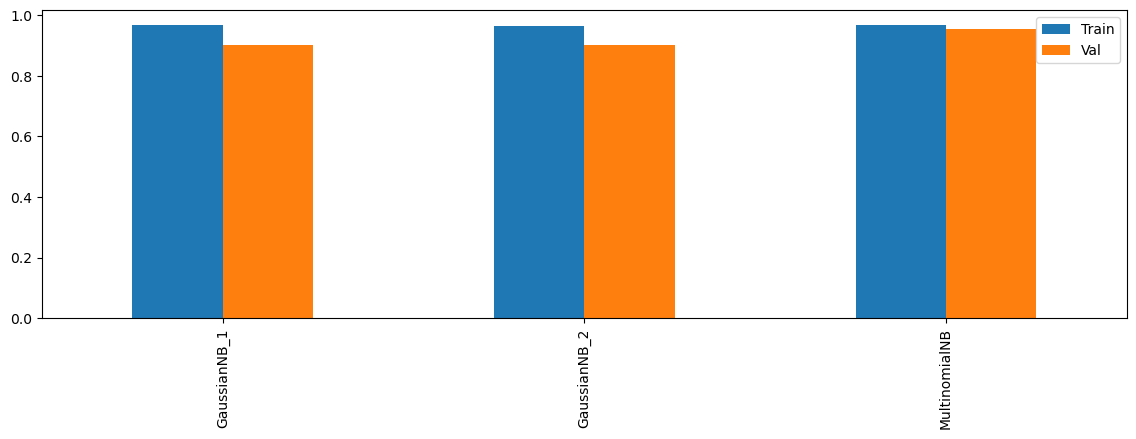

In [19]:
df_NB.plot(kind='bar',figsize=(14,4))

## Model 2: Support Vector Classifer, fixed in Week 8

First LinearSVC model

In [271]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [272]:
#Initialize the linear SVC model
LSVC = LinearSVC()

In [273]:
LSVC.fit(X_train, y_train)

/Users/tedwen/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [274]:
y_pred1 = LSVC.predict(X_train)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred1)))
y_pred2 = LSVC.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred2)))

Model training accuracy score: 0.9725
Model validation accuracy score: 0.9785


Second LinearSVC model using GridSearchCV

In [275]:
#define the search space for the grid search 
search_space = {'C': [0.01, 0.1, 1, 10], 
                'class_weight': [None, 'balanced']}

In [276]:
LSVC2 = LinearSVC()

In [277]:
#grid search 
model_grid = GridSearchCV(estimator=LSVC2,
                          param_grid=search_space)

In [278]:
model_grid.fit(X_train, y_train)

/Users/tedwen/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tedwen/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tedwen/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tedwen/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tedwen/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ted

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'class_weight': [None, 'balanced']})

In [279]:
# Print model score and best parameters
print('Best score:', model_grid.best_score_) 
print('Best C:', model_grid.best_estimator_.C)
print('Best class weights:', model_grid.best_estimator_.class_weight) 

Best score: 0.9718728462357797
Best C: 0.01
Best class weights: None


In [280]:
y_pred=model_grid.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model validation accuracy score: 0.9776


Third SVC model, none linear

In [281]:
from sklearn.svm import SVC

In [282]:
model = SVC()
model.fit(X_train, y_train)

SVC()

In [283]:
y_pred=model.predict(X_train)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
y_pred=model.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model training accuracy score: 0.9060
Model validation accuracy score: 0.9130


Based on training and validation accuracy scores, Linear SVC models are better than the SVC model.

Model Comparison Table

In [20]:
Training=['0.9725','0.9718','0.9060']
Validation=['0.9785','0.9776','0.9130']

col={'Train':Training,'Val':Validation}
models=['LinearSVC_1','LinearSVC_2','SVC']
df_NB=pd.DataFrame(col,index=models)
df_NB=df_NB.astype(float)
df_NB

,Train,Val
LinearSVC_1,0.9725,0.9785
LinearSVC_2,0.9718,0.9776
SVC,0.9060,0.9130


<AxesSubplot: >

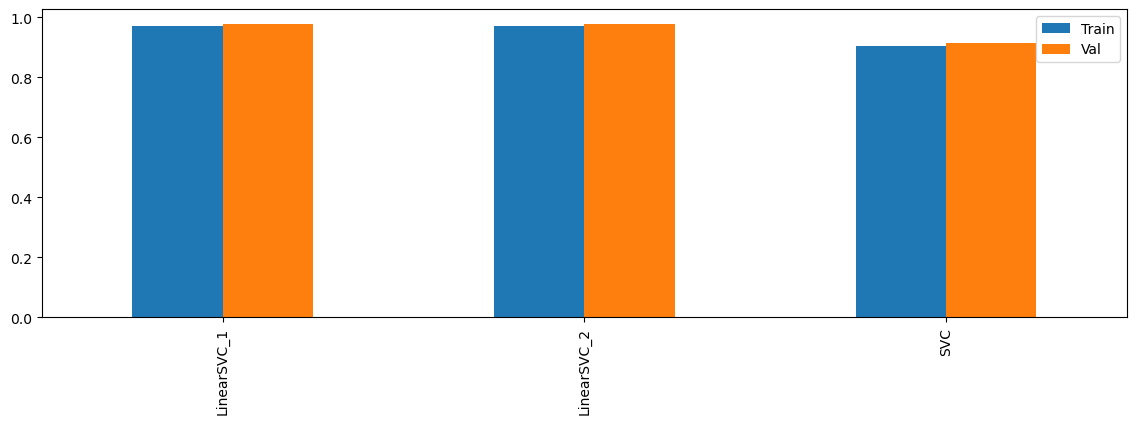

In [21]:
df_NB.plot(kind='bar',figsize=(14,4))

## Model 3: Random Forest, fixed in week 8

In [284]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

In [285]:
#create the default random forest model
rf1 = RandomForestClassifier(n_estimators = 10)
rf1_model = rf1.fit(X_train,y_train)

In [286]:
#Get performance metrics for the model based on the validation set
y_pred=rf1_model.predict(X_train)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
y_pred=rf1_model.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model training accuracy score: 0.9973
Model validation accuracy score: 0.9803


Second RF model with 100 trees

In [287]:
#random forest model with 100 trees
rf2 = RandomForestClassifier(n_estimators = 100)
rf2_model = rf2.fit(X_train,y_train)

In [288]:
#Get performance metrics for the model based on the validation set
y_pred=rf2_model.predict(X_train)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
y_pred=rf2_model.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model training accuracy score: 1.0000
Model validation accuracy score: 0.9821


Third RF model with a gridsearch for best hyperparameters

In [144]:
from sklearn.model_selection import GridSearchCV,\
RandomizedSearchCV

In [145]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

This GirdSearchCV takes about 20 minutes to run

In [146]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=25)


In [147]:
rf3 = RandomForestClassifier(max_depth=9,
                             max_features=None,
                             max_leaf_nodes=9,
                             n_estimators=25)
rf3_model = rf3.fit(X_train,y_train)

In [148]:
y_pred=rf3_model.predict(X_train)
print('Model training accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred)))
y_pred=rf3_model.predict(X_val)
print('Model validation accuracy score: {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model training accuracy score: 0.9800
Model validation accuracy score: 0.9785


In [22]:
Training=['0.9973','1.0000','0.9800']
Validation=['0.9803','0.9821','0.9785']

col={'Train':Training,'Val':Validation}
models=['rf_1','rf_2','rf_3']
df_NB=pd.DataFrame(col,index=models)
df_NB=df_NB.astype(float)
df_NB

,Train,Val
rf_1,0.9973,0.9803
rf_2,1.0000,0.9821
rf_3,0.9800,0.9785


<AxesSubplot: >

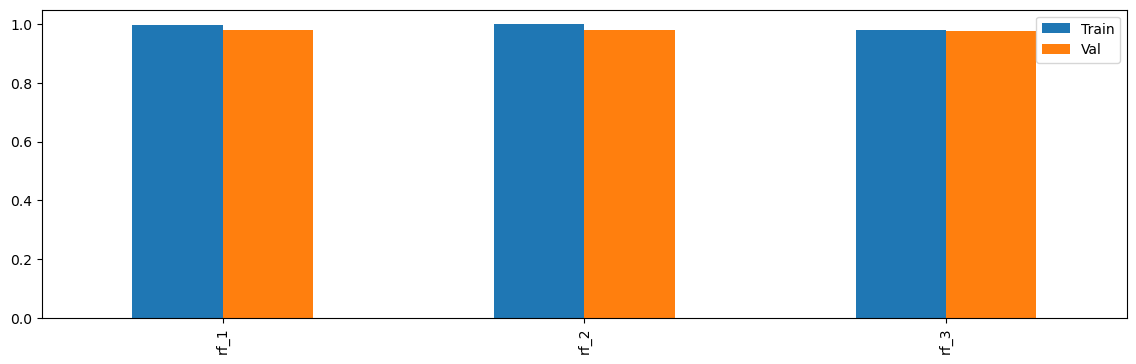

In [23]:
df_NB.plot(kind='bar',figsize=(14,4))